In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("darkgrid")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
train_dir="/kaggle/input/traffic-density-singapore/Final Dataset/training"
val_dir="/kaggle/input/traffic-density-singapore/Final Dataset/validation"
test_dir="/kaggle/input/traffic-density-singapore/Final Dataset/testing"

classes=['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']

batch_size=8
device="cuda"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [4]:
directories=[train_dir,val_dir,test_dir]
img_shapes=[]

for i,directory in enumerate(directories):
    for density_dir_name in os.listdir(directory):
        density_dir_path=os.path.join(directory,density_dir_name)
        for img_file_name in os.listdir(density_dir_path):
            img_path=os.path.join(density_dir_path,img_file_name)
            img=cv2.imread(img_path)
            img_shapes.append([img.shape[0],img.shape[1],directory.split("/")[-1]])
            
img_shape_data=pd.DataFrame(data=img_shapes,columns=["height","width","split"])

In [5]:
img_shape_data.groupby("split")[["height","width"]].describe().T

split             testing     training   validation
height count   320.000000  3378.000000   340.000000
       mean    411.093750   402.775311   399.158824
       std     106.509852    99.681314    82.614208
       min     119.000000   130.000000   163.000000
       25%     360.000000   360.000000   360.000000
       50%     360.000000   360.000000   360.000000
       75%     480.000000   480.000000   480.000000
       max    1252.000000  2832.000000   800.000000
width  count   320.000000  3378.000000   340.000000
       mean    626.071875   609.701599   615.964706
       std     146.682642   134.039099    97.736651
       min     111.000000   250.000000   275.000000
       25%     640.000000   640.000000   640.000000
       50%     640.000000   640.000000   640.000000
       75%     640.000000   640.000000   640.000000
       max    1920.000000  4256.000000  1200.000000

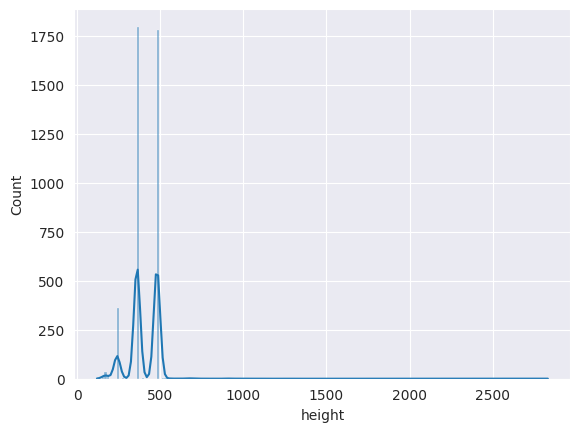

In [6]:
sns.histplot(img_shape_data["height"],kde=True);

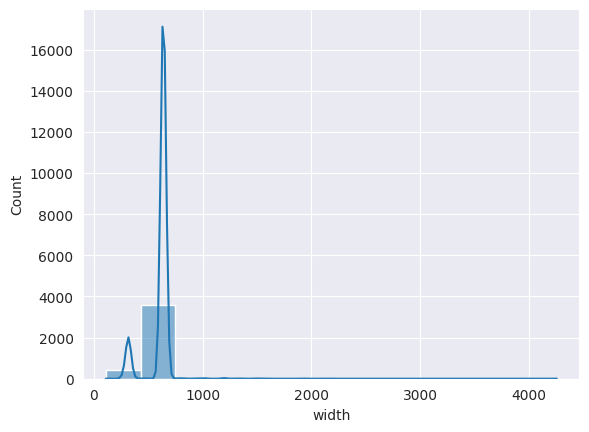

In [7]:
sns.histplot(img_shape_data["width"],kde=True);

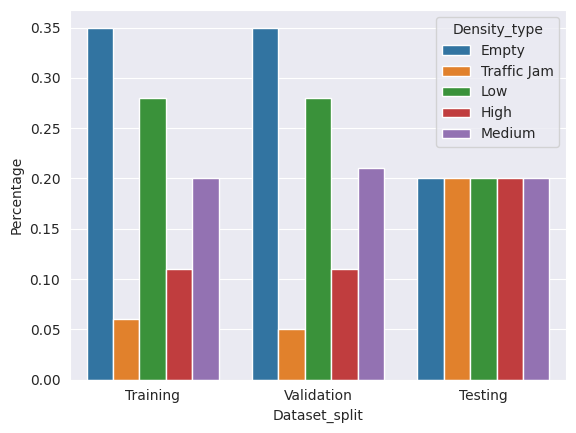

In [8]:
directories=[train_dir,val_dir,test_dir]
total_instances=[3378,340,320]
instances_list=[]
for i,directory in enumerate(directories):
    for density_dir_name in os.listdir(directory):
        density_dir_path=os.path.join(directory,density_dir_name)
        instances=round(len(os.listdir(density_dir_path))/total_instances[i],2)
        instances_list.append([directory.split("/")[-1].capitalize(),density_dir_name,
                               instances])

inter=pd.DataFrame(data=instances_list,columns=["Dataset_split","Density_type","Percentage"])
sns.barplot(data=inter,x="Dataset_split",y="Percentage",hue="Density_type");

In [9]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=5,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=400,width=600),
                           A.Normalize(),
                           ToTensorV2()])
                           
val_transform=A.Compose([A.Resize(height=400,width=600),
                         A.Normalize(),
                         ToTensorV2()])

In [10]:
def open_img(img_path):
    img=Image.open(img_path)
    img=np.array(img) 
    if img.shape[2]==3:
        return img
    else:
        return img[:,:,:-1]

class Transform():
    def __init__(self,transform):
        self.transform=transform
    def __call__(self,image):
        return self.transform(image=image)["image"]

In [11]:
train_ds=ImageFolder(train_dir,transform=Transform(train_transform),loader=open_img)
val_ds=ImageFolder(val_dir,transform=Transform(val_transform),loader=open_img)
test_ds=ImageFolder(test_dir,transform=Transform(val_transform),loader=open_img)

In [12]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if device is "cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  pin_memory=True if device is "cuda" else False)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                   pin_memory=True if device is "cuda" else False)

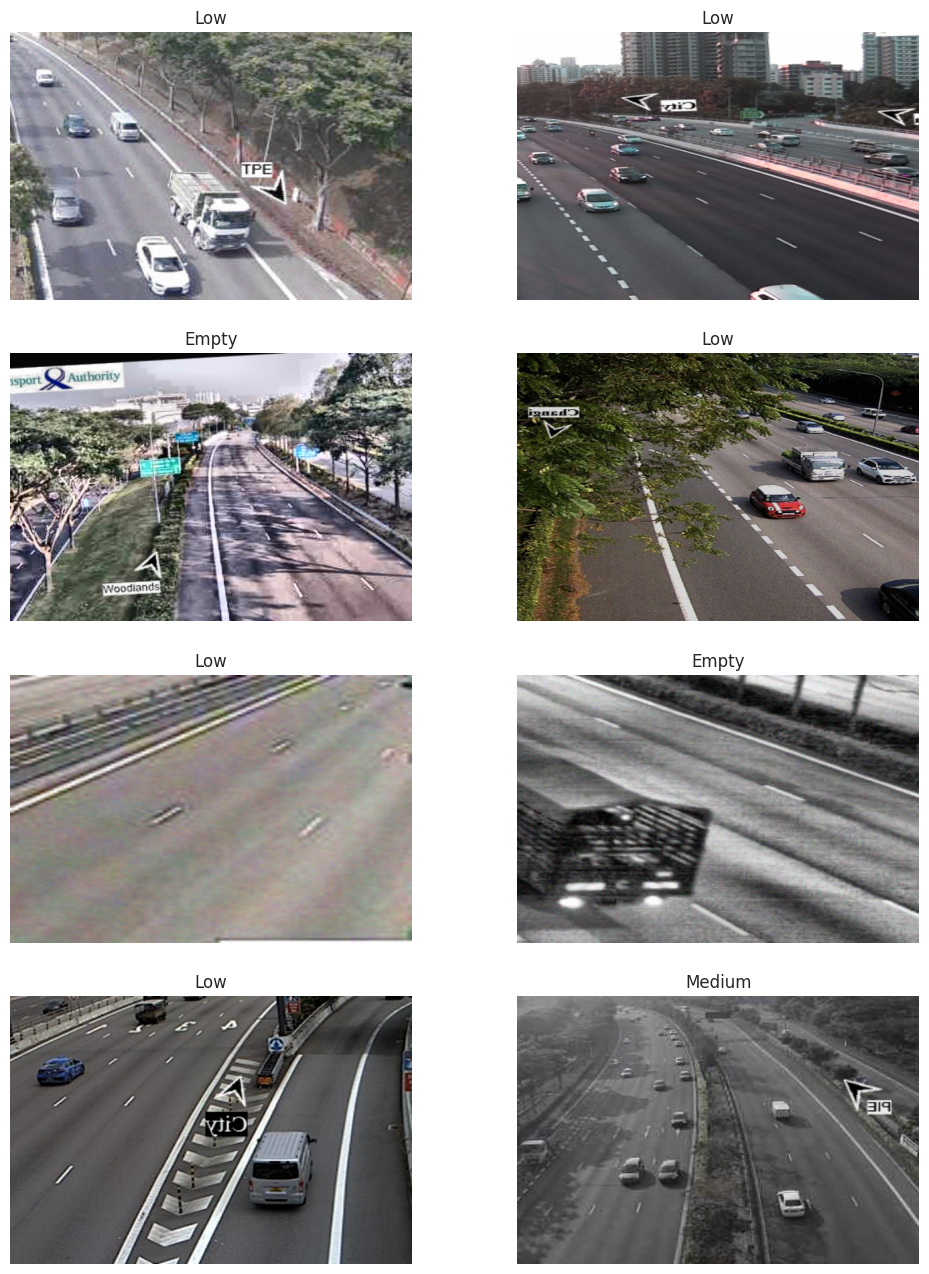

In [13]:
fig,axes=plt.subplots(4,2,figsize=(12,16))
ax=axes.flatten()
imgs,labels=next(iter(train_dl))


for i,img in enumerate(imgs):
    imgp=np.transpose(img.numpy().copy(),(1,2,0))*std+mean
    ax[i].imshow(imgp)
    ax[i].set_title(classes[labels[i].item()])
    ax[i].axis("off")

In [14]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]
    
def training(model,epochs,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,weights_path):
    best_val_acc=0.0
    patience=10
    best_weights=copy.deepcopy(model.state_dict())
    loss_dict={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
    
    for epoch in range(epochs):
        
        train_loss=0.0
        train_acc=0.0
        train_len=len(train_dl.dataset)
        val_loss=0.0
        val_acc=0.0
        val_len=len(val_dl.dataset)
        current_lr=get_lr(optimizer)
        
        model.train()
        for imgs,labels in train_dl:
            imgs,labels=imgs.to(device),labels.to(device)
            output=model(imgs)
            loss=loss_fn(output,labels)
            
            train_loss+=loss.item()
            pred_labels=output.argmax(dim=1)
            train_acc+=(labels==pred_labels).sum().item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
        with torch.no_grad():
            for imgs,labels in val_dl:
                imgs,labels=imgs.to(device),labels.to(device)
                output=model(imgs)
                loss=loss_fn(output,labels)
                
                val_loss+=loss.item()
                pred_labels=output.argmax(dim=1)
                val_acc+=(labels==pred_labels).sum().item()
            
        lr_scheduler.step(val_loss)
        if current_lr!=get_lr(optimizer):
            print("Loading best Model weights")
            model.load_state_dict(best_weights)
            
        if val_acc>best_val_acc:
            best_val_acc=val_acc
            best_weights=copy.deepcopy(model.state_dict())
            print("Updating Best Model weights")
            
        loss_dict["train_loss"].append(train_loss/train_len)  
        loss_dict["train_acc"].append(train_acc/train_len)
        loss_dict["val_loss"].append(val_loss/val_len)  
        loss_dict["val_acc"].append(val_acc/val_len)
        
        print(f"{epoch+1}/{epochs}: Training\nloss: {train_loss/train_len} accuracy: {train_acc/train_len}")
        print(f"{epoch+1}/{epochs}: Evaluating\nloss: {val_loss/val_len} accuracy: {val_acc/val_len}") 
        print("*"*50,"\n")
        
    torch.save(best_weights,weights_path)
    return loss_dict

In [15]:
def get_model(weights=None):
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(in_features=in_features,out_features=5)
    model.to(device)
    
    return model

In [16]:
weights=EfficientNet_B0_Weights.DEFAULT
model=get_model(weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 48.8MB/s]


In [17]:
for name,params in model.named_children():
    if name!="classifier":
        params.requires_grad=False
    
optimizer=optim.Adam(model.classifier.parameters(),lr=1e-3)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
extractor_weights_path="/kaggle/working/extractor_model.pth"

In [18]:
loss_dict=training(model,25,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   extractor_weights_path)

Updating Best Model weights
1/25: Training
loss: 1.1391128017183871 accuracy: 0.53700414446418
1/25: Evaluating
loss: 0.73456312417984 accuracy: 0.7235294117647059
************************************************** 

2/25: Training
loss: 0.9568569779466637 accuracy: 0.6080521018354056
2/25: Evaluating
loss: 0.6903042849372415 accuracy: 0.711764705882353
************************************************** 

Updating Best Model weights
3/25: Training
loss: 0.8963694055098764 accuracy: 0.6370633510953226
3/25: Evaluating
loss: 0.6443678613971261 accuracy: 0.7294117647058823
************************************************** 

Updating Best Model weights
4/25: Training
loss: 0.8848872854555762 accuracy: 0.6326228537596211
4/25: Evaluating
loss: 0.6139317505499896 accuracy: 0.7470588235294118
************************************************** 

5/25: Training
loss: 0.8786422503354494 accuracy: 0.6474245115452931
5/25: Evaluating
loss: 0.6388903263737173 accuracy: 0.7264705882352941
*********

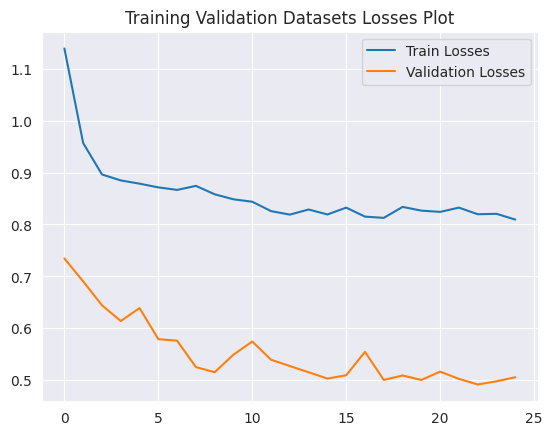

In [19]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

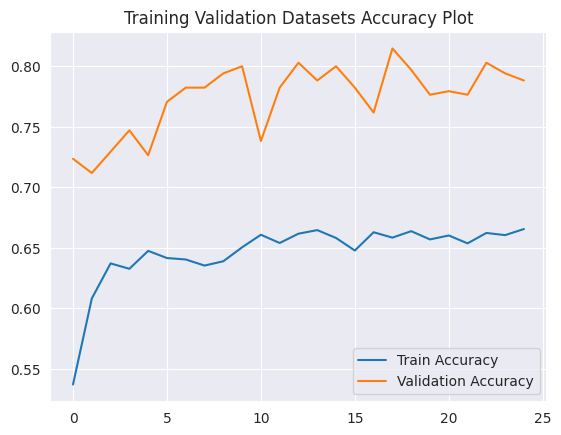

In [20]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

In [21]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/extractor_model.pth"))

<All keys matched successfully>

In [22]:
optimizer=optim.Adam(model.parameters(),lr=3e-5,weight_decay=1e-4)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
finetuning_weights_path="/kaggle/working/finetuning_model.pth"

In [23]:
loss_dict=training(model,50,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   finetuning_weights_path)

Updating Best Model weights
1/50: Training
loss: 0.7790569701160885 accuracy: 0.6823564239194789
1/50: Evaluating
loss: 0.45847146309473935 accuracy: 0.8235294117647058
************************************************** 

2/50: Training
loss: 0.7392375943504049 accuracy: 0.6983422143280047
2/50: Evaluating
loss: 0.43358091063359205 accuracy: 0.8205882352941176
************************************************** 

Updating Best Model weights
3/50: Training
loss: 0.6750216630302356 accuracy: 0.7276494967436353
3/50: Evaluating
loss: 0.4016095354276545 accuracy: 0.8294117647058824
************************************************** 

Updating Best Model weights
4/50: Training
loss: 0.6508859896038749 accuracy: 0.7386027235050325
4/50: Evaluating
loss: 0.38008156585342745 accuracy: 0.8470588235294118
************************************************** 

Updating Best Model weights
5/50: Training
loss: 0.6412822286217363 accuracy: 0.7353463587921847
5/50: Evaluating
loss: 0.3700747563996736 ac

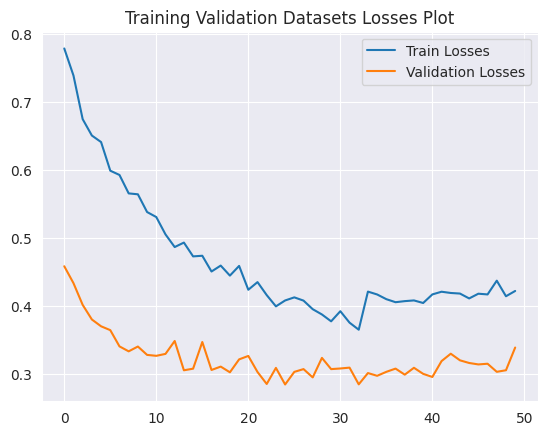

In [24]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

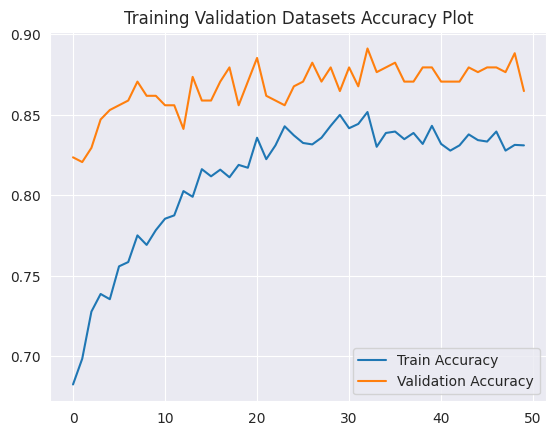

In [25]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

In [26]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/input/traffic-density-classification-learned-weights/finetuning_model.pth"))

<All keys matched successfully>

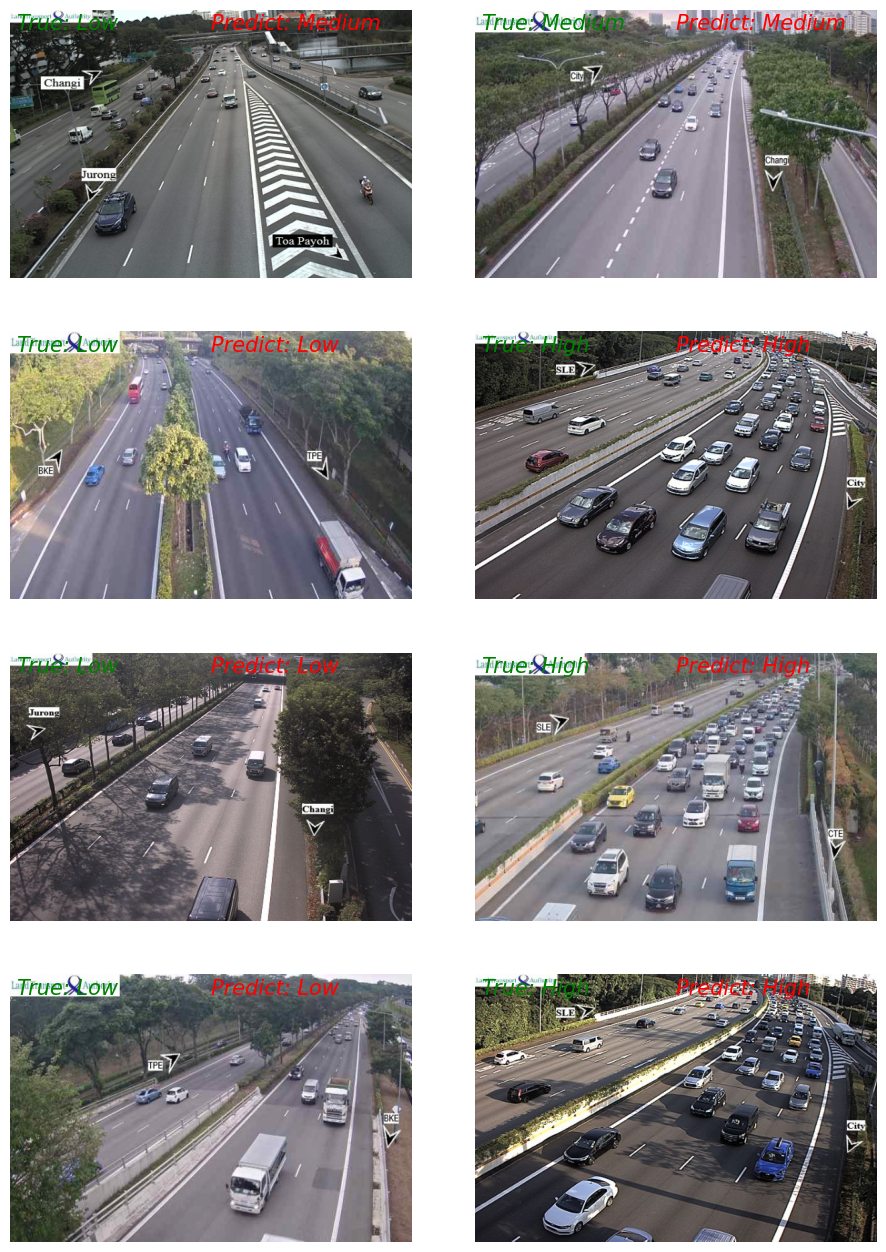

In [27]:
fig,axes=plt.subplots(4,2,figsize=(12,16))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()

imgs,labels=next(iter(test_dl))
model.eval()
with torch.no_grad():
    imgs=imgs.to(device)
    output=model(imgs)

for i in range(imgs.shape[0]):
    pred_label=output[i].argmax(0)
    ax[i].imshow(imgs[i].permute(1,2,0).cpu().numpy()*std+mean)
    ax[i].text(10,30,"True: "+ classes[labels[i].item()],style ='italic',
               fontsize = 15, color ="green")
    ax[i].text(300,30,"Predict: "+ classes[pred_label.item()],style ='italic',
                fontsize = 15, color ="red")
    ax[i].axis("off")
    
plt.savefig("6.png");

In [28]:
y_true=[]
y_pred=[]
model.eval()
with torch.no_grad():
    for j,(imgs,labels) in enumerate(test_dl):
        imgs,labels=imgs.to(device),labels.to(device)
        output=model(imgs)
        pred_labels=output.argmax(dim=1)
        y_true+=labels.tolist()
        y_pred+=pred_labels.tolist()

In [29]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        64
           1       0.90      0.94      0.92        64
           2       0.90      0.95      0.92        64
           3       0.89      0.88      0.88        64
           4       1.00      0.95      0.98        64

    accuracy                           0.93       320
   macro avg       0.94      0.93      0.93       320
weighted avg       0.94      0.93      0.93       320



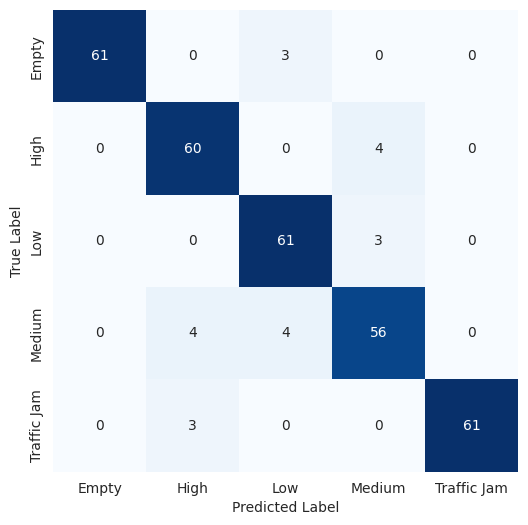

In [30]:
plt.figure(figsize=(6,6));
val=['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']
plot_data=pd.DataFrame(confusion_matrix(y_true,y_pred),columns=val,index=val)

sns.heatmap(plot_data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');
plt.savefig("7.png");